In [67]:
%pip install ccxt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [146]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta

binance = ccxt.binance()

def obtener_datos(symbol='BTC/USDT', timeframe='1m', dias=10):
    # Calcular las fechas de inicio y fin
    fecha_fin = datetime.utcnow()  # Fecha y hora actuales en UTC
    fecha_inicio = fecha_fin - timedelta(days=dias - 1)  # Restar 'dias - 1' días desde la fecha actual

    # Convertir fechas a timestamp en milisegundos
    timestamp_inicio = int(fecha_inicio.timestamp() * 1000)
    timestamp_fin = int(fecha_fin.timestamp() * 1000)

    # Obtener datos en lotes hasta cubrir el rango de fechas
    velas = binance.fetch_ohlcv(symbol, timeframe=timeframe, since=timestamp_inicio, limit=None)

    # Crear un DataFrame de pandas
    df = pd.DataFrame(velas, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    return df

# Obtener datos de BTC/USDT para los últimos 10 días
datos = obtener_datos(symbol='BTC/USDT', dias=10)
print(datos.head())  # Mostrar los primeros registros para verificar



C:\Users\Emiliano\AppData\Local\Temp\ipykernel_2904\3723284982.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fecha_fin = datetime.utcnow()  # Fecha y hora actuales en UTC


            timestamp      open      high       low     close    volume
0 2024-07-09 06:18:00  57404.50  57406.00  57358.00  57368.00  14.25110
1 2024-07-09 06:19:00  57368.00  57407.36  57356.86  57372.00  28.85034
2 2024-07-09 06:20:00  57372.00  57414.39  57372.00  57379.07  11.35304
3 2024-07-09 06:21:00  57379.06  57488.02  57379.06  57479.22  18.96753
4 2024-07-09 06:22:00  57479.21  57486.59  57436.89  57486.59  22.75781


In [140]:
print(datos)

              timestamp      open      high       low     close     volume
0   2024-07-09 06:20:00  57372.00  57542.36  57372.00  57498.00  147.40851
1   2024-07-09 06:25:00  57498.00  57692.98  57490.00  57590.00  196.31572
2   2024-07-09 06:30:00  57589.99  57754.00  57548.48  57562.00  144.86873
3   2024-07-09 06:35:00  57562.00  57711.99  57560.20  57576.02   98.72800
4   2024-07-09 06:40:00  57576.02  57576.02  57456.95  57553.84  105.31584
..                  ...       ...       ...       ...       ...        ...
495 2024-07-10 23:35:00  57739.52  57814.09  57731.07  57804.22   28.39040
496 2024-07-10 23:40:00  57804.23  57879.58  57796.28  57873.37   58.64420
497 2024-07-10 23:45:00  57873.38  57873.38  57760.52  57760.53   35.76385
498 2024-07-10 23:50:00  57760.53  57769.31  57715.01  57721.69   20.40448
499 2024-07-10 23:55:00  57721.69  57768.06  57716.88  57725.85   23.59048

[500 rows x 6 columns]


In [147]:
def calcular_emas(df):
    df['ema7'] = df['close'].ewm(span=7, adjust=False).mean()
    df['ema99'] = df['close'].ewm(span=99, adjust=False).mean()
    return df

datos = calcular_emas(datos)


In [ ]:
print(datos)

In [158]:
import pandas as pd

def ejecutar_backtesting(df):
    capital_inicial = 1000
    capital = capital_inicial
    posicion_abierta = False
    cantidad_btc = 0
    historial_operaciones = []

    # Iterar sobre los datos
    for i in range(1, len(df)):
        # Identificar cuando la EMA(7) es igual a la EMA(99) y esperar al siguiente cambio
        if df['ema7'][i] == df['ema99'][i]:
            continue
        
        # Cuando la EMA(7) es mayor a la EMA(99), comprar si no hay posición abierta
        if df['ema7'][i] > df['ema99'][i] and not posicion_abierta:
            cantidad_btc = capital / df['close'][i]
            capital = 0
            posicion_abierta = True
            precio_compra = df['close'][i]
            historial_operaciones.append({'accion': 'Compra', 'timestamp': df['timestamp'][i], 'precio': precio_compra})
            print(f"Comprar en {df['timestamp'][i]} a {precio_compra:.2f}")
        
        # Cuando la EMA(99) es mayor a la EMA(7), vender si hay posición abierta
        elif df['ema99'][i] > df['ema7'][i] and posicion_abierta:
            capital = cantidad_btc * df['close'][i]
            cantidad_btc = 0
            posicion_abierta = False
            precio_venta = df['close'][i]
            ganancia = capital - capital_inicial
            historial_operaciones.append({'accion': 'Venta', 'timestamp': df['timestamp'][i], 'precio': precio_venta, 'ganancia': ganancia})
            print(f"Vender en {df['timestamp'][i]} a {precio_venta:.2f}, Ganancia/Perdida: {ganancia:.2f}")

    # Vender la posición abierta al final del período si aún está abierta
    if posicion_abierta:
        capital = cantidad_btc * df['close'].iloc[-1]
        ganancia = capital - capital_inicial
        historial_operaciones.append({'accion': 'Venta', 'timestamp': df['timestamp'].iloc[-1], 'precio': df['close'].iloc[-1], 'ganancia': ganancia})
        print(f"Vender en {df['timestamp'].iloc[-1]} a {df['close'].iloc[-1]:.2f}, Ganancia/Perdida: {ganancia:.2f}")

    # Calcular el rendimiento final
    rendimiento = ganancia
    print(f"Rendimiento final: {rendimiento:.2f}%")

    # Retornar historial de operaciones como DataFrame
    historial_operaciones_df = pd.DataFrame(historial_operaciones)
    return historial_operaciones_df

# Ejemplo de cómo usar la función ejecutar_backtesting con datos de un DataFrame df que tiene 'ema7', 'ema99', 'close' y 'timestamp'
# Asegúrate de tener los datos preparados antes de llamar a esta función

historial_operaciones_df = ejecutar_backtesting(datos)



Comprar en 2024-07-09 06:19:00 a 57372.00
Vender en 2024-07-09 07:10:00 a 57422.00, Ganancia/Perdida: 0.87
Comprar en 2024-07-09 08:15:00 a 57410.51
Vender en 2024-07-09 10:15:00 a 57547.85, Ganancia/Perdida: 3.27
Comprar en 2024-07-09 11:28:00 a 57490.00
Vender en 2024-07-09 11:50:00 a 57420.01, Ganancia/Perdida: 2.04
Comprar en 2024-07-09 12:01:00 a 57488.70
Vender en 2024-07-09 12:05:00 a 57378.98, Ganancia/Perdida: 0.13
Comprar en 2024-07-09 12:12:00 a 57465.65
Vender en 2024-07-09 12:24:00 a 57366.79, Ganancia/Perdida: -1.59
Comprar en 2024-07-09 12:50:00 a 57555.06
Vender en 2024-07-09 12:56:00 a 57348.30, Ganancia/Perdida: -5.18
Comprar en 2024-07-09 14:00:00 a 57407.20
Vender en 2024-07-09 14:05:00 a 57184.60, Ganancia/Perdida: -9.03
Comprar en 2024-07-09 14:11:00 a 57460.01
Vender en 2024-07-09 14:37:00 a 57670.31, Ganancia/Perdida: -5.41
Rendimiento final: -5.41%


In [149]:
print(historial_operaciones_df)
historial_operaciones_df.to_csv('ruta_csv', index=False)

    accion           timestamp    precio  ganancia
0   Compra 2024-07-09 06:19:00  57372.00       NaN
1    Venta 2024-07-09 07:10:00  57422.00  0.871505
2   Compra 2024-07-09 08:15:00  57410.51       NaN
3    Venta 2024-07-09 10:15:00  57547.85  3.265835
4   Compra 2024-07-09 11:28:00  57490.00       NaN
5    Venta 2024-07-09 11:50:00  57420.01  2.044430
6   Compra 2024-07-09 12:01:00  57488.70       NaN
7    Venta 2024-07-09 12:05:00  57378.98  0.131979
8   Compra 2024-07-09 12:12:00  57465.65       NaN
9    Venta 2024-07-09 12:24:00  57366.79 -1.588580
10  Compra 2024-07-09 12:50:00  57555.06       NaN
11   Venta 2024-07-09 12:56:00  57348.30 -5.175259
12  Compra 2024-07-09 14:00:00  57407.20       NaN
13   Venta 2024-07-09 14:05:00  57184.60 -9.032754
14  Compra 2024-07-09 14:11:00  57460.01       NaN
15   Venta 2024-07-09 14:37:00  57670.31 -5.405877


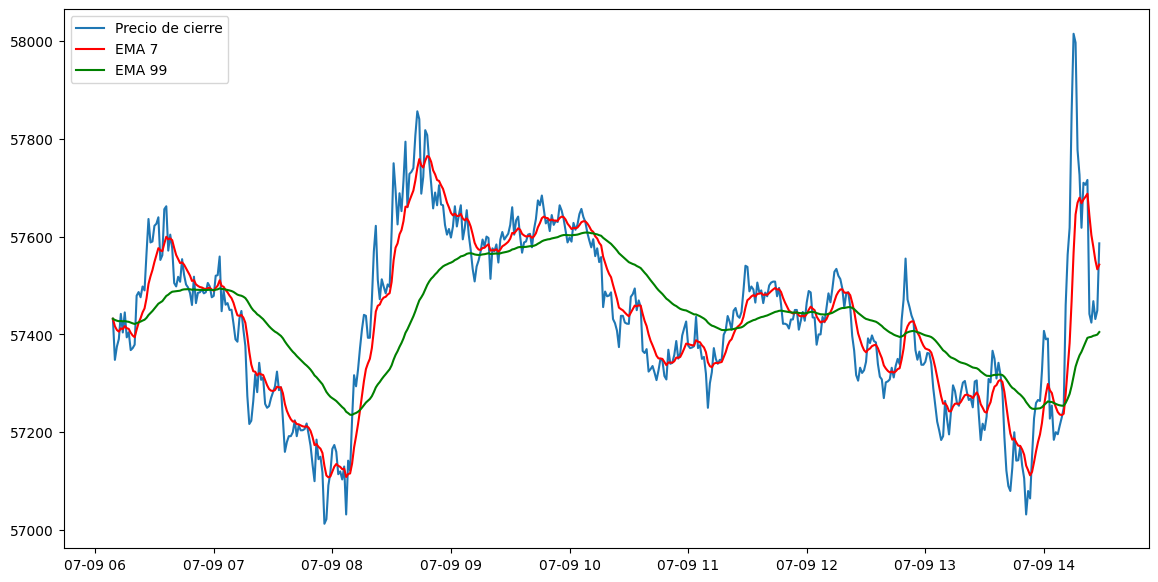

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(datos['timestamp'], datos['close'], label='Precio de cierre')
plt.plot(datos['timestamp'], datos['ema7'], label='EMA 7', color='r')
plt.plot(datos['timestamp'], datos['ema99'], label='EMA 99', color='g')
plt.legend()
plt.show()
